In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import deeptrack as dt
import deeptrack.deeplay as dl
import utils
from custom_lodestar import customLodeSTAR

MODEL_PATH = "../models/4p38uxku/PusherPuller_weights.pth"
IMAGE_PATH = "../data/PusherPuller_02/images/Ms_4_4_AuNP_moving_n0_laser_2_40_005_008.png"
CONFIG_PATH = "config.yaml"

config = utils.load_yaml(CONFIG_PATH)

if config['lodestar_version'] == 'default':
    model = dl.LodeSTAR(
        n_transforms=config['n_transforms'], 
        optimizer=dl.Adam(lr=config['lr'])
    ).build()
else:
    model = customLodeSTAR(
        n_transforms=config['n_transforms'], 
        optimizer=dl.Adam(lr=config['lr'])
    ).build()

model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
print(f"Model loaded from {MODEL_PATH}")

/opt/mona_jupyterhub_env/lib/python3.10/site-packages/deeptrack/__init__.py:13: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


Model loaded from ../models/4p38uxku/PusherPuller_weights.pth


In [2]:
image = np.array(dt.LoadImage(IMAGE_PATH).resolve()).astype(np.float32)
if len(image.shape) == 3:
    if image.shape[-1] == 3:
        image = np.dot(image[..., :3], [0.299, 0.587, 0.114])
    elif image.shape[-1] == 1:
        image = image[..., 0]
print(f"Image shape: {image.shape}")
print(f"Image range: [{image.min():.4f}, {image.max():.4f}]")

image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float()
print(f"Tensor shape: {image_tensor.shape}")

with torch.no_grad():
    model_output = model(image_tensor)
print(f"Model output shape: {model_output.shape}")
print(f"Output channels: {model_output.shape[1]} (expected: X, Y, weights)")

weights = model_output[0, -1].detach().numpy()
print(f"\n=== STEP 1: Weight Map ===")
print(f"Weights shape: {weights.shape}")
print(f"Weights range (sigmoid): [{weights.min():.4f}, {weights.max():.4f}]")
print(f"Weights mean: {weights.mean():.4f}")
print(f"Weights std: {weights.std():.4f}")

Image shape: (1024, 1024)
Image range: [0.0000, 255.0000]
Tensor shape: torch.Size([1, 1, 1024, 1024])
Model output shape: torch.Size([1, 3, 512, 512])
Output channels: 3 (expected: X, Y, weights)

=== STEP 1: Weight Map ===
Weights shape: (512, 512)
Weights range (sigmoid): [0.0002, 0.9996]
Weights mean: 0.0169
Weights std: 0.0414


In [3]:
h, w = image.shape
if weights.shape != (h, w):
    weights_resized = cv2.resize(weights, (w, h), interpolation=cv2.INTER_LINEAR)
    print(f"Weights resized from {weights.shape} to {weights_resized.shape}")
else:
    weights_resized = weights
    print("No resizing needed")

cutoff = 0.9#config.get('cutoff', 0.9)
print(f"\n=== STEP 2: Binarization (cutoff={cutoff}) ===")
binary_mask = (weights_resized > cutoff).astype(np.uint8)
print(f"Binary mask shape: {binary_mask.shape}")
print(f"Foreground pixels: {binary_mask.sum()} / {binary_mask.size} ({100*binary_mask.sum()/binary_mask.size:.2f}%)")

Weights resized from (512, 512) to (1024, 1024)

=== STEP 2: Binarization (cutoff=0.9) ===
Binary mask shape: (1024, 1024)
Foreground pixels: 694 / 1048576 (0.07%)


In [4]:
print(f"\n=== STEP 3: Find Contours ===")
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Number of contours found: {len(contours)}")

disk_config = config.get('disk_detection', {})
min_area = 200 # disk_config.get('min_area', 100)
max_area = 500# disk_config.get('max_area', 2500)
min_circularity = 0.7 # disk_config.get('min_circularity', 0.7)


=== STEP 3: Find Contours ===
Number of contours found: 1


In [5]:
print(f"\n=== STEP 4: Filter Contours ===")
print(f"Filter params: min_area={min_area}, max_area={max_area}, min_circularity={min_circularity}")
print("-" * 60)

detections = []
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    if perimeter == 0:
        circularity = 0
    else:
        circularity = 4 * np.pi * area / (perimeter ** 2)
    
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = M["m10"] / M["m00"]
        cy = M["m01"] / M["m00"]
    else:
        cx, cy = 0, 0
    
    area_ok = min_area <= area <= max_area
    circ_ok = circularity >= min_circularity
    passed = area_ok #and circ_ok
    
    status = "✓ PASS" if passed else "✗ FAIL"
    reason = []
    if not area_ok:
        if area < min_area:
            reason.append(f"area too small")
        else:
            reason.append(f"area too large")
    if not circ_ok:
        reason.append(f"not circular enough")
    #if cx > 800 and cx < 850 and cy > 780 and cy < 800:
        
    if passed:
        detections.append([cx, cy, area, circularity])
        print(f"Contour {i}: area={area:.1f}, circularity={circularity:.3f}, center=({cx:.1f}, {cy:.1f}) -> {status} {', '.join(reason)}")


=== STEP 4: Filter Contours ===
Filter params: min_area=200, max_area=500, min_circularity=0.7
------------------------------------------------------------


------------------------------------------------------------
Total detections after filtering: 0


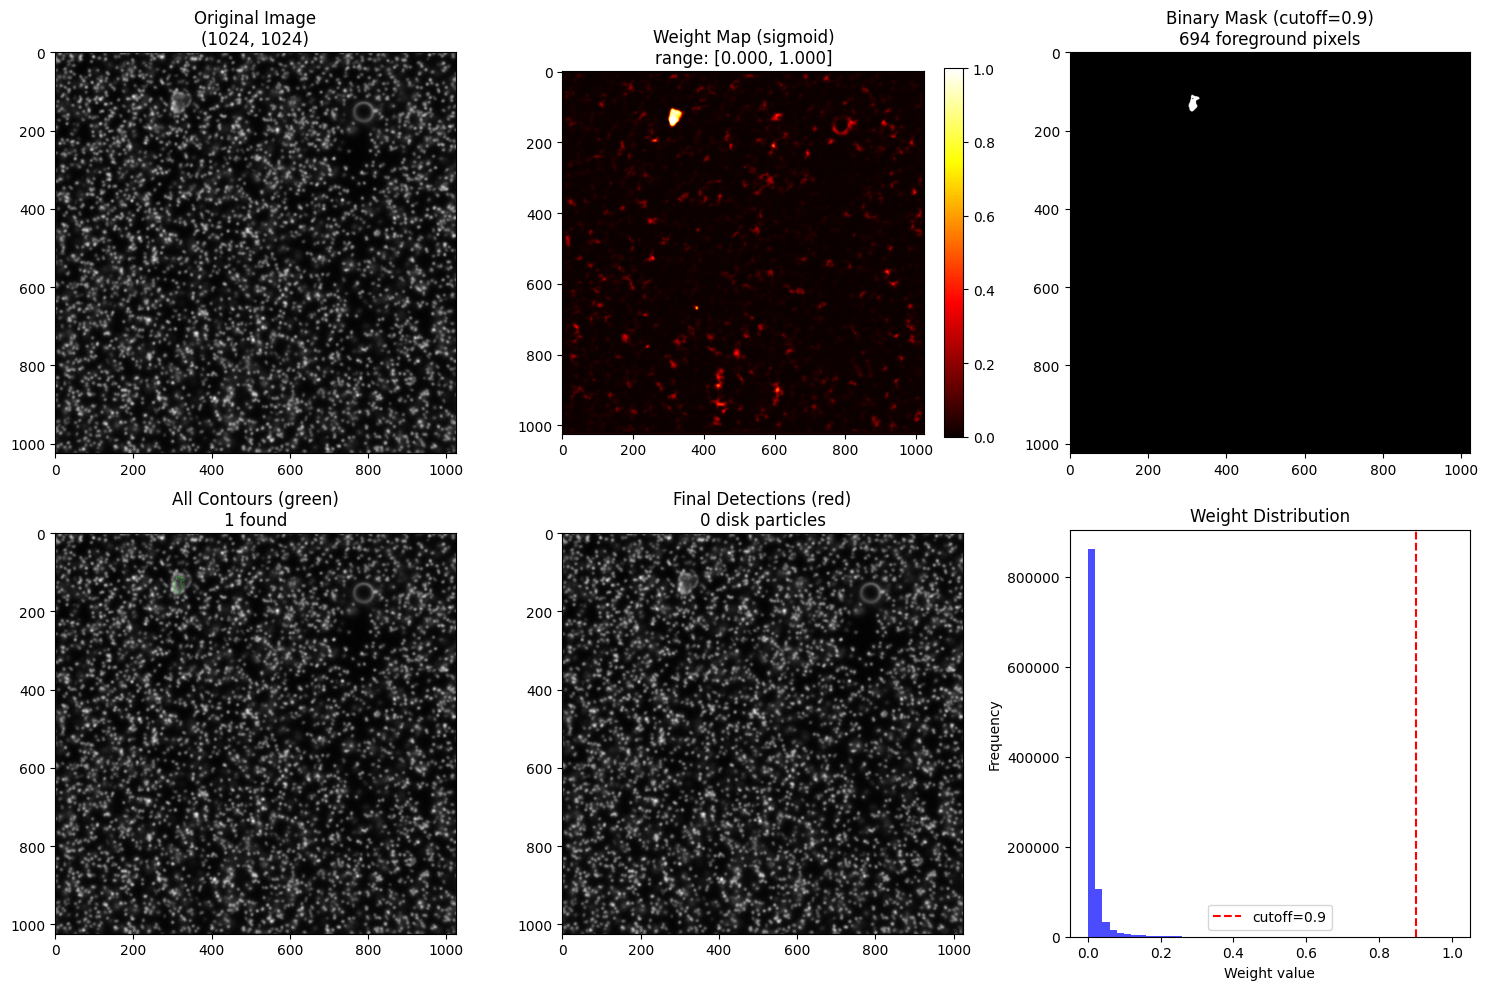


Visualization saved to: debug_disk_detection_output.png


In [6]:
print("-" * 60)
print(f"Total detections after filtering: {len(detections)}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title(f"Original Image\n{image.shape}")
axes[0, 0].axis('on')

im1 = axes[0, 1].imshow(weights_resized, cmap='hot', vmin=0, vmax=1)
axes[0, 1].set_title(f"Weight Map (sigmoid)\nrange: [{weights_resized.min():.3f}, {weights_resized.max():.3f}]")
axes[0, 1].axis('on')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

axes[0, 2].imshow(binary_mask, cmap='gray')
axes[0, 2].set_title(f"Binary Mask (cutoff={cutoff})\n{binary_mask.sum()} foreground pixels")
axes[0, 2].axis('on')

contour_img = cv2.cvtColor((image / image.max() * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 1)
axes[1, 0].imshow(contour_img)
axes[1, 0].set_title(f"All Contours (green)\n{len(contours)} found")
axes[1, 0].axis('on')

detection_img = cv2.cvtColor((image / image.max() * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
for det in detections:
    cx, cy = int(det[0]), int(det[1])
    cv2.circle(detection_img, (cx, cy), 5, (255, 0, 0), 2)
    cv2.circle(detection_img, (cx, cy), 1, (255, 0, 0), -1)
axes[1, 1].imshow(detection_img)
axes[1, 1].set_title(f"Final Detections (red)\n{len(detections)} disk particles")
axes[1, 1].axis('on')

axes[1, 2].hist(weights_resized.flatten(), bins=50, color='blue', alpha=0.7)
axes[1, 2].axvline(cutoff, color='red', linestyle='--', label=f'cutoff={cutoff}')
axes[1, 2].set_xlabel('Weight value')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Weight Distribution')
axes[1, 2].legend()

plt.tight_layout()
#plt.savefig('debug_disk_detection_output.png', dpi=150)
plt.show()
print(f"\nVisualization saved to: debug_disk_detection_output.png")